In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate

## Loading Data

In [186]:
df = pd.read_csv("term-deposit-marketing-2020.csv")

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [6]:
df.shape

(40000, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


## Correlation between columns

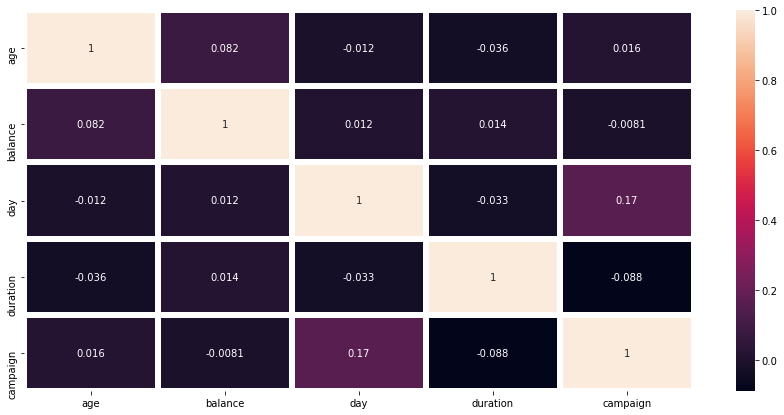

In [69]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),linewidths=5, annot=True)

In [8]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [187]:
index = df[(df["job"] == "unknown") & (df["education"] == "unknown")].index

In [188]:
df = df.drop(index, 0)

In [189]:
df.shape

(39896, 14)

## Creating X and y

In [190]:
X = df.drop(["contact", 'y'], 1)
y = df['y']

In [217]:
labels = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month']
for i in labels:
    print(X[i].value_counts())

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           131
Name: job, dtype: int64
married     24306
single      10870
divorced     4720
Name: marital, dtype: int64
secondary    20993
tertiary     11206
primary       6270
unknown       1427
Name: education, dtype: int64
no     39088
yes      808
Name: default, dtype: int64
yes    24024
no     15872
Name: housing, dtype: int64
no     32966
yes     6930
Name: loan, dtype: int64
may    13520
jul     6371
aug     5190
jun     4691
nov     3595
apr     2713
feb     2294
jan     1172
mar      258
oct       79
dec       13
Name: month, dtype: int64


## Creating X_num (numeric) and X_label (categorical)

In [191]:
X_num = X[["age", "balance", "day", "duration", "campaign"]]

In [192]:
X_label = X[['job', 'marital', 'education', 'default', 'housing', 'loan', 'month']]

In [193]:
X_label = X_label.replace({'job':{"unknown":"blue-collar"}, 'education':{"unknown":"secondary"}})  # "unknown" variables replaced with mod of columns 

## Using get_dummies for categorical columns

In [218]:
X_cat = [pd.get_dummies(X_label[i], sparse = False, prefix = i) for i in labels]

## Concatenating

In [221]:
X_ = [X_num] + X_cat

In [222]:
X_ = pd.concat(X_, axis=1)

In [223]:
X_.shape

(39896, 39)

## Using GridSearchCV for best parameters

In [70]:
from sklearn.model_selection import GridSearchCV

In [75]:
parameters = {"max_depth": [4,5,6,7,8,9,10]
            ,"min_samples_split" :[2,3,4]
            ,"min_samples_leaf": [3,4,5]
            ,"max_features": (4,"sqrt")
            ,"criterion": ('gini','entropy')}

rf_regr = RandomForestClassifier()
rf_model = GridSearchCV(rf_regr,parameters, n_jobs = -1, cv = 5)
rf_model_fit = rf_model.fit(X_,y)

learned_parameters = rf_model_fit.best_params_ 

In [76]:
classifier = RandomForestClassifier(max_depth = learned_parameters["max_depth"]
                            ,max_features = learned_parameters['max_features']
                            ,min_samples_leaf = learned_parameters['min_samples_leaf']
                            ,min_samples_split = learned_parameters['min_samples_split']
                            ,criterion = learned_parameters['criterion']
                            ,n_estimators = 1000)

In [77]:
classifier.fit(X_, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [209]:
import joblib

In [210]:
joblib.dump(classifier, "rf.joblib")

['rf.joblib']

## Cross-validation

*Although I used different models such as Logistic regression, Naive Bayes, KNN, I got the best result in Random Forest Classifier.*

In [78]:
val = cross_validate(classifier, X_, y, return_train_score=True, cv=5)

In [79]:
print("train score:", val["train_score"].mean())
print("test score:", val["test_score"].mean())

train score: 0.9276932522094267
test score: 0.9275365943370772


# Bonus


* We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

* What makes the customers buy? Tell us which feature we should be focusing more on.

### Most profitable segments

I divided the customers into 50 clusters and identified the cluster with the highest y-column average in these classes as the 19th cluster.

In [80]:
from sklearn.cluster import KMeans

In [156]:
model = KMeans(n_clusters = 50)
model.fit(X_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [157]:
clusters = model.predict(X_)

In [202]:
df.y = df.y.replace({"yes":1, "no":0})

In [197]:
y = y.replace({"yes":1, "no":0})

In [198]:
df["group"] = clusters

In [245]:
df.groupby("group")["y"].mean().sort_values(ascending=False).head()

group
19    0.607595
21    0.484496
40    0.241908
7     0.150301
49    0.149333
Name: y, dtype: float64

In [252]:
numeric = ["age", "balance", "day", "duration", "campaign"]

In [258]:
def mode(s):
    return s.mode()[0]

In [268]:
df.groupby("group") \
    .agg(dict(y = "mean", **{col:"mean" for col in numeric}, **{col: mode for col in labels})) \
    .sort_values("y", ascending= False).assign(group_size= df.groupby("group")["y"].count()).head(10)

,y,age,balance,day,duration,campaign,job,marital,education,default,housing,loan,month,group_size
group,,,,,,,,,,,,,,
19,0.607595,40.911392,2807.620253,23.696203,320.696203,1.000000,management,married,secondary,no,yes,no,oct,79
21,0.484496,41.054264,1894.193798,14.612403,221.643411,2.523256,management,married,tertiary,no,no,no,mar,258
40,0.241908,37.831346,1458.229983,18.250426,290.352641,1.885860,management,married,tertiary,no,yes,no,apr,587
7,0.150301,27.601202,1277.997996,15.250501,237.639279,2.607214,student,single,secondary,no,no,no,may,499
49,0.149333,38.538667,1049.213333,17.218667,285.952000,1.821333,admin,married,secondary,no,yes,no,apr,375
37,0.140083,39.325936,1138.615811,5.597781,239.901526,2.434119,management,married,tertiary,no,no,no,feb,721
44,0.107616,38.643212,1382.048841,16.629139,311.732616,1.943709,blue-collar,married,secondary,no,yes,no,apr,1208
12,0.102256,57.020301,1347.074436,15.464662,258.439850,2.642857,retired,married,secondary,no,no,no,may,1330
9,0.089783,41.113519,1415.540764,14.535604,281.766770,2.517028,unemployed,married,secondary,no,no,no,may,969


### Feature Importances

* We ranked the classification according to the importance of the features and show the 5 most important features below. In this context, it is seen that the most important feature is "duration". Having this feature in the range of 600-800 will increase the success.

In [234]:
fi = pd.Series(classifier.feature_importances_, index = X_.columns).sort_values(ascending = False).rename("importance").to_frame()

In [235]:
fi["feature"] = pd.Series(fi.index, index=fi.index).apply(lambda x:x.split("_")[0])

In [246]:
fi.groupby("feature")["importance"].sum().sort_values(ascending= False).head()

feature
duration    0.481367
month       0.230379
age         0.060716
housing     0.054179
marital     0.044013
Name: importance, dtype: float64

(-100.0, 2200.0)

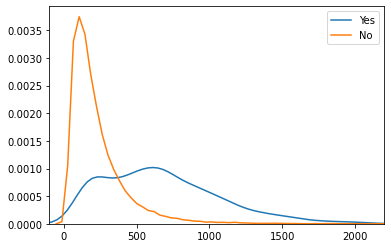

In [243]:
sns.kdeplot(df[df["y"]==1]["duration"], label= "Yes")
sns.kdeplot(df[df["y"]==0]["duration"], label= "No")
plt.xlim(-100, 2200) 